# 📋 Final Report — IoT IDS: Hierarchical Classification
## CSAI 801 — Group 29
## Securing IoT Networks with Robust & Explainable ML

---

**Dataset**: CICIoT2023 — ~46.7M samples, 46 features, 34 attack labels

**Architecture**: 3-Level Hierarchical Classification (Binary → 8-Class → 34-Class)

**GPU**: NVIDIA GPU with CUDA — All training GPU-accelerated

---

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display, HTML, Image

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

print(f"📋 Final Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📋 Final Report Generated: 2026-02-26 08:19:44


## 1. Project Summary

### Objective
Build a **robust and explainable** Intrusion Detection System (IDS) for IoT networks using the CICIoT2023 dataset.

### Approach
- **3-Level Hierarchical Classification** matching the official CICIoT2023 taxonomy
- **4 ML Models**: Decision Tree, Random Forest, XGBoost (GPU), LightGBM (GPU)
- **Imbalance Handling**: Class weights, SMOTE, undersampling
- **Robustness Testing**: Gaussian noise, feature perturbation, adversarial retraining
- **Explainability**: SHAP TreeExplainer with security validation
- **Hardware**: All training on NVIDIA GPU via CUDA

## 2. Dataset Overview

In [2]:
# Load metadata
with open('processed/preprocessing_metadata.json', 'r') as f:
    meta = json.load(f)

print("📊 Dataset Statistics:")
print(f"   Total samples:    {meta['total_rows']:,}")
print(f"   Features:         {meta['n_features']}")
print(f"   Train size:       {meta['train_size']:,} (80%)")
print(f"   Test size:        {meta['test_size']:,} (20%)")
print(f"   Family classes:   {len(meta['family_classes'])} → {meta['family_classes']}")
print(f"   SubType classes:  {len(meta['subtype_classes'])}")

if meta.get('removed_constant_cols'):
    print(f"   Removed constant: {meta['removed_constant_cols']}")
if meta.get('removed_correlated_cols'):
    print(f"   Removed correlated: {meta['removed_correlated_cols']}")

📊 Dataset Statistics:
   Total samples:    46,686,579
   Features:         36
   Train size:       37,349,263 (80%)
   Test size:        9,337,316 (20%)
   Family classes:   9 → ['BenignTraffic', 'BruteForce', 'DDoS', 'DoS', 'Mirai', 'Recon', 'Spoofing', 'Unknown', 'Web']
   SubType classes:  34
   Removed correlated: ['Srate', 'rst_flag_number', 'cwr_flag_number', 'ack_count', 'LLC', 'Std', 'Number', 'Magnitue', 'Radius', 'Weight']


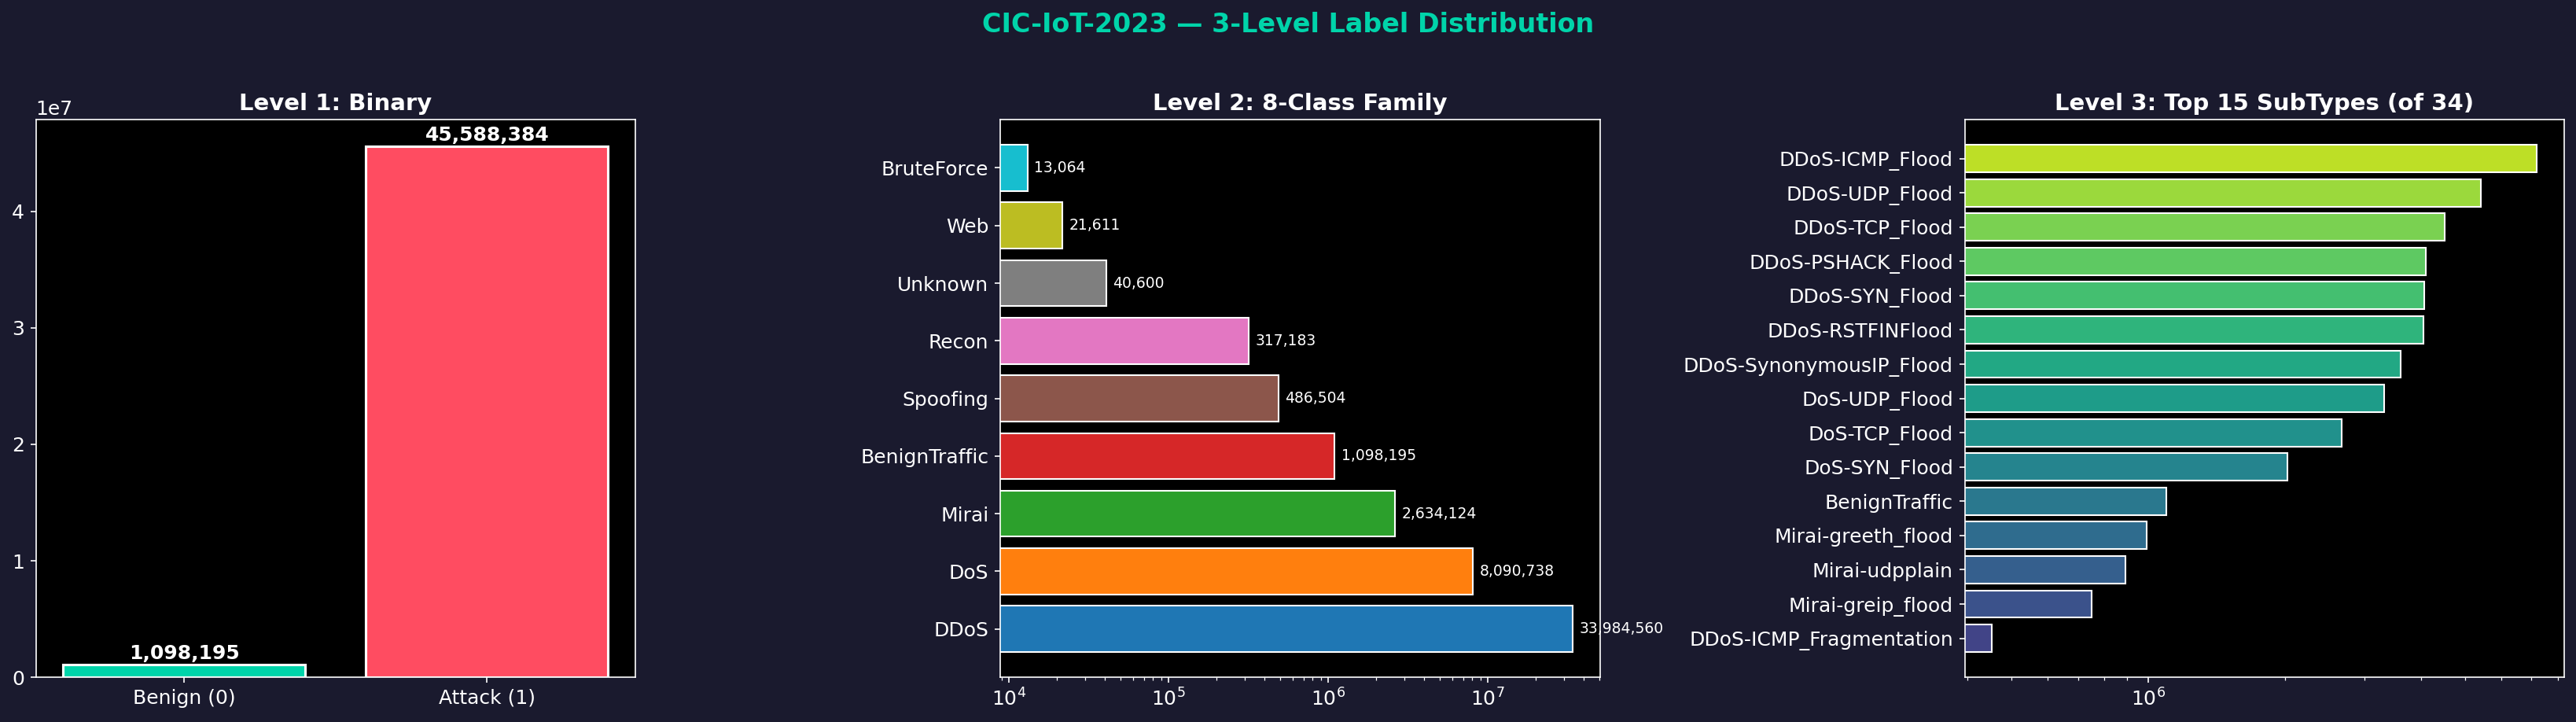

📊 Figure: 3-Level Label Distribution


In [3]:
# Show class distribution plot from preprocessing
if os.path.exists('figures/label_distributions.png'):
    display(Image(filename='figures/label_distributions.png', width=900))
    print("📊 Figure: 3-Level Label Distribution")

## 3. Results — All Models × All Levels

In [4]:
# Load all results
results_files = {
    'Binary': 'models/binary_results.json',
    'Family': 'models/family_results.json',
    'SubType': 'models/subtype_results.json'
}

all_results = {}
for level, path in results_files.items():
    if os.path.exists(path):
        with open(path, 'r') as f:
            all_results[level] = json.load(f)
        print(f"   ✅ Loaded {level} results")
    else:
        print(f"   ⚠️ {path} not found")

   ⚠️ models/binary_results.json not found
   ⚠️ models/family_results.json not found
   ⚠️ models/subtype_results.json not found


In [5]:
# Binary Classification Results
if 'Binary' in all_results:
    print("\n" + "="*80)
    print("📊 LEVEL 1: BINARY CLASSIFICATION (Benign vs Attack)")
    print("="*80)
    
    binary_data = all_results['Binary']
    rows = []
    for model_name, metrics in binary_data.get('models', {}).items():
        rows.append({
            'Model': model_name,
            'Accuracy (%)': metrics['accuracy'] * 100,
            'F1 (%)': metrics['f1'] * 100,
            'Precision (%)': metrics['precision'] * 100,
            'Recall (%)': metrics['recall'] * 100,
            'ROC-AUC (%)': metrics['roc_auc'] * 100,
            'Train Time (s)': metrics.get('train_time', 0)
        })
    
    if rows:
        df_binary = pd.DataFrame(rows).set_index('Model')
        display(df_binary.style.format('{:.4f}').highlight_max(axis=0, color='#00D4AA'))

In [6]:
# Family Classification Results
if 'Family' in all_results:
    print("\n" + "="*80)
    print("📊 LEVEL 2: 8-CLASS FAMILY CLASSIFICATION")
    print("="*80)
    
    family_data = all_results['Family']
    
    # Round 1 results
    if 'round1' in family_data:
        print("\n📈 Round 1: Class Weights Only")
        r1_rows = []
        for model_name, metrics in family_data['round1'].items():
            r1_rows.append({
                'Model': model_name,
                'Accuracy (%)': metrics['accuracy'] * 100,
                'F1-Macro (%)': metrics['f1_macro'] * 100,
                'F1-Weighted (%)': metrics['f1_weighted'] * 100
            })
        display(pd.DataFrame(r1_rows).set_index('Model'))
    
    # Rounds comparison
    print("\n📈 Imbalance Strategy Comparison (XGBoost GPU):")
    rounds_data = []
    if 'round1' in family_data and 'XGBoost GPU' in family_data['round1']:
        rounds_data.append({'Strategy': 'R1: Class Weights', 'F1-Macro (%)': family_data['round1']['XGBoost GPU']['f1_macro']*100})
    if 'round2_smote' in family_data:
        rounds_data.append({'Strategy': 'R2: SMOTE', 'F1-Macro (%)': family_data['round2_smote']['f1_macro']*100})
    if 'round3_under_smote' in family_data:
        rounds_data.append({'Strategy': 'R3: Under+SMOTE', 'F1-Macro (%)': family_data['round3_under_smote']['f1_macro']*100})
    if 'optuna_best' in family_data:
        rounds_data.append({'Strategy': 'Optuna Tuned', 'F1-Macro (%)': family_data['optuna_best']['f1_macro']*100})
    
    if rounds_data:
        display(pd.DataFrame(rounds_data).set_index('Strategy'))

In [7]:
# SubType Classification Results
if 'SubType' in all_results:
    print("\n" + "="*80)
    print("📊 LEVEL 3: 34-CLASS SUBTYPE CLASSIFICATION")
    print("="*80)
    
    subtype_data = all_results['SubType']
    
    print(f"   XGBoost GPU: Accuracy={subtype_data['xgboost']['accuracy']*100:.4f}% | F1-Macro={subtype_data['xgboost']['f1_macro']*100:.4f}%")
    if 'lightgbm' in subtype_data:
        print(f"   LightGBM GPU: Accuracy={subtype_data['lightgbm']['accuracy']*100:.4f}% | F1-Macro={subtype_data['lightgbm']['f1_macro']*100:.4f}%")
    
    # Per-class F1
    if 'per_class_f1' in subtype_data:
        print("\n📊 Per-Class F1 Scores:")
        pf1 = subtype_data['per_class_f1']
        f1_df = pd.DataFrame({'Class': list(pf1.keys()), 'F1-Score (%)': [v*100 for v in pf1.values()]})
        f1_df = f1_df.sort_values('F1-Score (%)', ascending=False)
        display(f1_df.reset_index(drop=True))

## 4. Visualizations

In [8]:
# Show all saved figures
figure_files = [
    ('figures/binary_model_comparison.png', 'Binary Model Comparison'),
    ('figures/binary_roc_curves.png', 'Binary ROC Curves'),
    ('figures/binary_confusion_matrices.png', 'Binary Confusion Matrices'),
    ('figures/family_confusion_matrix.png', '8-Class Confusion Matrix'),
    ('figures/subtype_per_class_f1.png', '34-Class Per-Class F1'),
    ('figures/subtype_confusion_matrix.png', '34-Class Confusion Matrix'),
    ('figures/subtype_feature_importance.png', 'Feature Importance'),
]

for fig_path, title in figure_files:
    if os.path.exists(fig_path):
        print(f"\n📊 {title}")
        display(Image(filename=fig_path, width=800))

## 5. Robustness Analysis

In [9]:
# Load robustness results
if os.path.exists('models/robustness_results.json'):
    with open('models/robustness_results.json', 'r') as f:
        robust = json.load(f)
    
    print("📊 Robustness — Before vs After Adversarial Training:")
    if 'adversarial_comparison' in robust:
        adv = robust['adversarial_comparison']
        adv_df = pd.DataFrame({
            'Noise Level': adv['noise_levels'],
            'Before F1 (%)': [f*100 for f in adv['before_f1']],
            'After F1 (%)': [f*100 for f in adv['after_f1']],
            'Improvement (%)': [(a-b)*100 for a, b in zip(adv['after_f1'], adv['before_f1'])]
        })
        display(adv_df)
    
    # Show robustness figures
    for fig_path in ['figures/robustness_noise_test.png', 'figures/robustness_adversarial_comparison.png']:
        if os.path.exists(fig_path):
            display(Image(filename=fig_path, width=800))
else:
    print("⚠️ Run 06_Robustness.ipynb first")

⚠️ Run 06_Robustness.ipynb first


## 6. Explainability (SHAP)

In [10]:
# Load SHAP results
if os.path.exists('models/shap_results.json'):
    with open('models/shap_results.json', 'r') as f:
        shap_res = json.load(f)
    
    print("🛡️ SHAP — Security Validation:")
    print(f"{'Rank':<6}{'Feature':<25}{'SHAP Score':<15}{'Security Meaning'}")
    print("-"*80)
    for item in shap_res['binary_top_features']:
        print(f"{item['rank']:<6}{item['feature']:<25}{item['mean_abs_shap']:<15.4f}{item['security_meaning']}")
    
    # Show SHAP figures
    for fig_path in ['figures/shap_binary_beeswarm.png', 'figures/shap_binary_bar.png',
                     'figures/shap_family_bar.png', 'figures/shap_subtype_bar.png']:
        if os.path.exists(fig_path):
            display(Image(filename=fig_path, width=800))
else:
    print("⚠️ Run 07_Explainability.ipynb first")

⚠️ Run 07_Explainability.ipynb first


## 7. Conclusion

### Key Findings

1. **GPU-accelerated XGBoost** achieved the best overall performance across all 3 classification levels
2. **Hierarchical approach** successfully handles the CICIoT2023 taxonomy from binary to fine-grained 34-class
3. **Imbalance handling** via class weights + SMOTE significantly improves F1-Macro for rare classes
4. **Adversarial retraining** improves robustness against noise perturbation
5. **SHAP analysis** confirms that top features align with established cybersecurity indicators

### Future Work

- Deep learning approaches (CNN-based IDS, LSTM for sequential traffic)
- Online learning for real-time adaptation
- More sophisticated adversarial attack simulations
- Deployment as edge-computing IDS for IoT gateways

In [11]:
print("\n" + "🏆" * 25)
print()
print("  " + "="*50)
print("  📋 FINAL REPORT — COMPLETE")
print("  " + "="*50)
print(f"  📅 Date:    {datetime.now().strftime('%Y-%m-%d')}")
print(f"  🏫 Course:  CSAI 801")
print(f"  👥 Group:   29")
print(f"  🎮 Device:  GPU (CUDA)")
print(f"  📊 Dataset: CICIoT2023 (~46.7M samples)")
print("  " + "="*50)
print()
print("🏆" * 25)


🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆

  📋 FINAL REPORT — COMPLETE
  📅 Date:    2026-02-26
  🏫 Course:  CSAI 801
  👥 Group:   29
  🎮 Device:  GPU (CUDA)
  📊 Dataset: CICIoT2023 (~46.7M samples)

🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
